In [5]:
#https://github.com/vic22981106/RNN_BinaryAdditionTask/blob/master/RNN_BinaryAdditionTask.ipynb

# import the packages that I need
import numpy as np
import matplotlib.pyplot as plt
import random

np.random.seed(10)

def getSample(stringLength, testFlag):
  #takes stringlength as input
  #returns a sample for the network - an input sequence - x and its target -y
  #x is a T*2 array, T is the length of the string and 2 since we take one bit each from each string
  #testFlag if set prints the input numbers and its sum in both decimal and binary form
  lowerBound=pow(2,stringLength-1)+1
  upperBound=pow(2,stringLength)

  num1=random.randint(lowerBound,upperBound)
  num2=random.randint(lowerBound,upperBound)

  num3=num1+num2
  num3Binary=(bin(num3)[2:])
  num1Binary=(bin(num1)[2:])
  num2Binary=(bin(num2)[2:])

  if testFlag==1:
    print('input numbers and their sum are: ', num1, ', ', num2, ', ', num3)
    print ('binary strings are: ', num1Binary, ', ' , num2Binary, ', ' , num3Binary)
  len_num1= (len(num1Binary))
  len_num2= (len(num2Binary))
  len_num3= (len(num3Binary))

  # since num3 will be the largest, we pad  other numbers with zeros to that num3_len
  num1Binary= ('0'*(len(num3Binary)-len(num1Binary))+num1Binary)
  num2Binary= ('0'*(len(num3Binary)-len(num2Binary))+num2Binary)

  # forming the input sequence
  # the input at first timestep is the least significant bits of the two input binary strings
  # x will be then a len_num3 ( or T ) * 2 array
  x=np.zeros((len_num3,2),dtype=np.int)
  for i in range(0, len_num3):
    x[i,0]=num1Binary[len_num3-1-i] # note that MSB of the binary string should be the last input along the time axis
    x[i,1]=num2Binary[len_num3-1-i]
  # target vector is the sum in binary
  # convert binary string in <string> to a numpy 1D array
  y = np.fromiter(num3Binary[::-1], dtype=np.int)
  return x,y

# sigmoid function and its derivative
def sigmoid(x):
    #output = 1/(1+np.exp(-x))
    output = (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
    return output

def sigmoid_derivative(output):
    return 1-output**2 #output*(1-output)

# training dataset generation
int2binary = {}
binary_dim = 8

largest_number = pow(2,binary_dim)
binary = np.unpackbits(np.array([range(largest_number)],dtype=np.uint8).T,axis=1)
for i in range(largest_number):
    int2binary[i] = binary[i]

epoch = 20000
lr = 0.1
input_dim = 2
hidden_dim = 16
output_dim = 1

# initialize neural network weights
W_inputtohidden = 2*np.random.random((input_dim,hidden_dim)) - 1
W_hiddenToOutput = 2*np.random.random((hidden_dim,output_dim)) - 1
W_hiddenTohidden = 2*np.random.random((hidden_dim,hidden_dim)) - 1

# generate 3 lists to store the upcoming gradients
W_inputtohidden_update = np.zeros_like(W_inputtohidden)
W_hiddenToOutput_update = np.zeros_like(W_hiddenToOutput)
W_hiddenTohidden_update = np.zeros_like(W_hiddenTohidden)

allError=[]
Acc = []
# training logic
for j in range(epoch):
    # generate a simple addition problem (a + b = c)
    #a_int = np.random.randint(largest_number/2) # int version
    #a = int2binary[a_int] # binary version of a
    #b_int = np.random.randint(largest_number/2) # int version
    #b = int2binary[b_int] # binary verions of b

    # true answer
    #c_int = a_int + b_int # int version of c
    #c = int2binary[c_int] # binary version of c
    #print('a,b,c previous are: {},{},{}'.format(a,b,c))

    x,y = getSample(binary_dim-1,0)
    a = np.array(list(reversed(x[:,0])))
    b = np.array(list(reversed(x[:,1])))
    c = np.array(list(reversed(y)))
    print('a,b,c current  are: {},{},{}'.format(a,b,c))
    print('c[0] equals {}'.format(c[0]))
    # i generate an array d for the best answer given by the machine (binary version)
    d = np.zeros_like(c)
    overallError = 0

    outputlayer_deltas = list()
    hidden_values = list()
    hidden_values.append(np.zeros(hidden_dim))

    # moving along the positions in the binary encoding
    for position in range(binary_dim):
        # generate input and output , move from right to left
        X = np.array([[a[binary_dim - position - 1],b[binary_dim - position - 1]]])
        y = np.array([[c[binary_dim - position - 1]]]).T

        # forward propagation
        hidden=sigmoid(np.dot(X,W_inputtohidden) + np.dot(hidden_values[-1],W_hiddenTohidden))
        # output layer (new binary representation)
        outputlayer = sigmoid(np.dot(hidden,W_hiddenToOutput))

        # calculate the loss value
        outputlayer_error = y - outputlayer
        outputlayer_deltas.append((outputlayer_error)*sigmoid_derivative(outputlayer)*(-1))
        Error = ((outputlayer_error)**2)/2

        # decode estimate
        # print("The OutputLayer (binary version): ",outputlayer[0][0])
        d[binary_dim - position - 1] = np.round(outputlayer[0][0])

        # store hidden layer foro BPTT
        hidden_values.append(hidden)

    # generate an array to store the hidden and hidden_delta at t + 1 for BPTT
    future_hidden_delta = np.zeros(hidden_dim)
    future_hidden = np.zeros(hidden_dim)

    for position in range(binary_dim):
        X = np.array([[a[position],b[position]]])
        hidden = hidden_values[-position-1]
        prev_hidden = hidden_values[-position-2]

        # error at output layer
        outputlayer_delta = outputlayer_deltas[-position-1]

        # error at hidden layer * sigmoid_derivative(future_hidden)
        hidden_delta = (future_hidden_delta.dot(W_hiddenTohidden.T) *
                        sigmoid_derivative(future_hidden) +
                        outputlayer_delta.dot(W_hiddenToOutput.T)) * \
                       sigmoid_derivative(hidden)

        # update all weights
        W_hiddenToOutput_update += np.atleast_2d(hidden).T.dot(outputlayer_delta)
        W_hiddenTohidden_update += np.atleast_2d(prev_hidden).T.dot(hidden_delta)
        W_inputtohidden_update += X.T.dot(hidden_delta)
        future_hidden_delta = hidden_delta
        future_hidden = hidden

    W_inputtohidden -= W_inputtohidden_update * lr
    W_hiddenToOutput -= W_hiddenToOutput_update * lr
    W_hiddenTohidden -= W_hiddenTohidden_update * lr

    W_inputtohidden_update *= 0
    W_hiddenToOutput_update *= 0
    W_hiddenTohidden_update *= 0


    correct = 0
    wrong = 0
    for i in range(binary_dim):
        if d[i]==c[i]:
            correct += 1
        else:
            wrong += 1
    accuracy = correct / binary_dim *100
    overallError = wrong / binary_dim * 100
    if j%100 == 0:
        Acc.append(accuracy)
        allError.append(overallError)

    # print out result
    if(j %1000 == 0):
        print("epoch",j)
        print("Pred:" , d)
        print("True:" ,c)
        out = 0
        for index,x in enumerate(reversed(d)):
            out += x*pow(2,index)
        #print(a_int, " + ",b_int," = ",out)
        print("Error:",overallError)
        print("accuracy =", accuracy,"%")
        print("------------")

a,b,c current  are: [0 1 0 1 1 1 1 0],[1 0 0 0 0 0 0 0],[1 1 0 1 1 1 1 0]
c[0] equals 1
epoch 0
Pred: [-1 -1 -1 -1  0 -1  1  0]
True: [1 1 0 1 1 1 1 0]
Error: 75.0
accuracy = 25.0 %
------------
a,b,c current  are: [0 1 0 0 1 0 0 1],[0 1 1 0 0 1 1 1],[1 0 1 1 0 0 0 0]
c[0] equals 1
a,b,c current  are: [0 1 0 1 1 1 1 1],[0 1 0 1 0 1 1 1],[1 0 1 1 0 1 1 0]
c[0] equals 1
a,b,c current  are: [0 1 1 0 1 1 0 0],[0 1 0 1 1 0 1 1],[1 1 0 0 0 1 1 1]
c[0] equals 1
a,b,c current  are: [0 1 0 1 1 0 1 1],[0 1 1 0 1 1 1 1],[1 1 0 0 1 0 1 0]
c[0] equals 1
a,b,c current  are: [0 1 0 0 0 1 0 0],[0 1 1 1 0 0 1 0],[1 0 1 1 0 1 1 0]
c[0] equals 1
a,b,c current  are: [0 1 0 0 0 1 1 0],[0 1 0 0 0 1 0 1],[1 0 0 0 1 0 1 1]
c[0] equals 1
a,b,c current  are: [0 1 1 1 1 1 1 1],[0 1 1 1 0 0 0 0],[1 1 1 0 1 1 1 1]
c[0] equals 1
a,b,c current  are: [0 1 1 0 0 1 0 0],[0 1 0 0 1 1 1 0],[1 0 1 1 0 0 1 0]
c[0] equals 1
a,b,c current  are: [1 0 0 0 0 0 0 0],[0 1 0 0 0 1 1 0],[1 1 0 0 0 1 1 0]
c[0] equals 1
a,b,c current

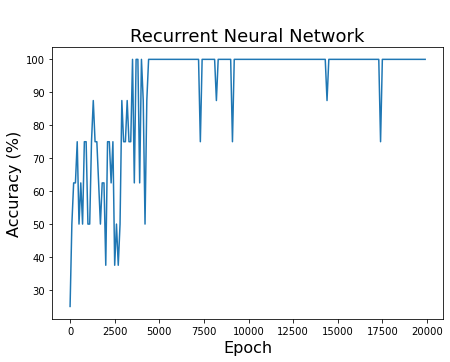

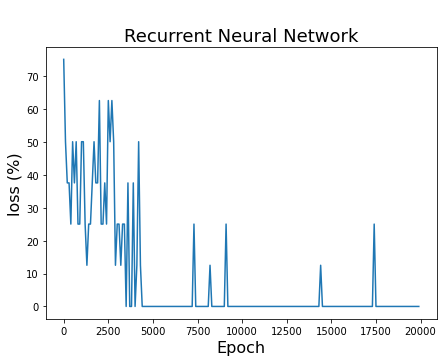

In [6]:
fig = plt.figure(figsize=(7,5))
epoch = np.arange(0,20000,100)
plt.plot(epoch,Acc,linestyle="solid")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Accuracy (%)",fontsize=16)
plt.title("\nRecurrent Neural Network",fontsize=18)
#plt.savefig('/Users/Anna/Desktop/RNN_Acc.png')
plt.show()

fig = plt.figure(figsize=(7,5))
epoch = np.arange(0,20000,100)
plt.plot(epoch,allError,linestyle="solid")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("loss (%)",fontsize=16)
plt.title("\nRecurrent Neural Network",fontsize=18)
#plt.savefig('/Users/vincent/Desktop/RNN_Loss.png')
plt.show()

In [4]:
for i in range(10):

    a_int = np.random.randint(largest_number/2)
    a = int2binary[a_int]
    b_int = np.random.randint(largest_number/2)
    b = int2binary[b_int]

    # true answer
    c_int = a_int + b_int
    c = int2binary[c_int]
    d = np.zeros_like(c)
    print('a,b,c current  are: {},{},{}'.format(a,b,c))

    hidden_values = list()
    hidden_values.append(np.zeros(hidden_dim))
    for position in range(binary_dim):
        # generate input and output , move from right to left
        X = np.array([[a[binary_dim - position - 1],b[binary_dim - position - 1]]])
        y = np.array([[c[binary_dim - position - 1]]]).T

        # forward propagation
        hidden=sigmoid(np.dot(X,W_inputtohidden) + np.dot(hidden_values[-1],W_hiddenTohidden))
        # output layer (new binary representation)
        outputlayer = sigmoid(np.dot(hidden,W_hiddenToOutput))
        d[binary_dim - position - 1] = np.round(outputlayer[0][0])
        # store hidden layer for BPTT
        hidden_values.append(hidden)


    out = 0
    for index,x in enumerate(reversed(d)):
        out += x*pow(2,index)

    # msg = '{:<5}{:^3}{:<5}{:^3}{:<5}'.format( a_int,"+", b_int,"=", out)
    # print(msg)
    # print("%-.5s + %-.5s = %-.5s" % (a_int, b_int, out))
    print(a_int, " + ",b_int," = ",out)


a,b,c current  are: [0 1 1 1 0 0 0 1],[0 0 0 1 0 0 0 0],[1 0 0 0 0 0 0 1]
113  +  16  =  129
a,b,c current  are: [0 1 0 1 0 0 1 0],[0 0 0 1 0 0 1 1],[0 1 1 0 0 1 0 1]
82  +  19  =  101
a,b,c current  are: [0 1 1 1 0 0 0 1],[0 1 1 1 0 1 0 0],[1 1 1 0 0 1 0 1]
113  +  116  =  229
a,b,c current  are: [0 1 1 1 0 0 1 0],[0 1 1 0 0 0 0 0],[1 1 0 1 0 0 1 0]
114  +  96  =  210
a,b,c current  are: [0 0 1 1 0 0 1 0],[0 1 0 1 1 0 0 0],[1 0 0 0 1 0 1 0]
50  +  88  =  138
a,b,c current  are: [0 1 1 0 1 0 0 0],[0 0 0 0 1 0 0 0],[0 1 1 1 0 0 0 0]
104  +  8  =  112
a,b,c current  are: [0 1 0 1 0 1 1 0],[0 1 1 1 0 1 0 1],[1 1 0 0 1 0 1 1]
86  +  117  =  203
a,b,c current  are: [0 1 0 0 1 0 1 1],[0 1 0 0 1 0 0 0],[1 0 0 1 0 0 1 1]
75  +  72  =  147
a,b,c current  are: [0 1 0 1 1 0 0 0],[0 1 1 0 1 0 0 0],[1 1 0 0 0 0 0 0]
88  +  104  =  192
a,b,c current  are: [0 0 0 1 1 0 1 0],[0 1 0 1 0 0 0 0],[0 1 1 0 1 0 1 0]
26  +  80  =  106
